# Munchausen Reinforcement Learning

### What is Munchausen RL?

In practice, Munchausen RL is simply the addition of an intrinsic reward term to Q-learning type algorithms. This additional term is the log of the density assigned to the action sampled at time $t$ by the target policy at time $t$.

For an example, consider Q-learning via the one-step temporal difference target TD(0):

$$q(s_t, a_t) \leftarrow r_t + \max_{a \in \mathcal{A}}q(s_{t+1}, a)$$

where beginning in state $s_t$ we sample $a_t$ according to current behavioural policy $a_t \sim \mu(\cdot | s_t)$, and observe a reward $r_t = \mathcal{R}(s_t, a_t)$ and transition $s_{t+1} \sim \mathcal{P}(\cdot|s_t, a_t)$.

The Munchausen equivalent M-TD(0) is:

$$q(s_t, a_t) \leftarrow r_t + \alpha \log\pi(a_t | s_t) + \max_{a \in \mathcal{A}}q(s_{t+1}, a)$$

Where $\pi$ is the current target policy, i.e. $\pi(a | s) = \delta(\arg \max_{a \in \mathcal{A}} q(a, s))$. Notice that we have introduced a hyperparameter to weight the log-policy term.

Easy!

### Soft Setting: Munchausen RL only well-defined for target policy with same support as behavioural policy:

Before we discuss _why_ we might want to do this, notice that we need to be careful about the support of our target policy versus our behavioural policy. In particular, this additional term is going to be problematic if we choose to do off-policy learning with a deterministic target policy as above. In this case, any time we sample an $a_t \sim \mu(\cdot | s_t)$ such that $a_t \neq \max_{a \in \mathcal{A}} q(a, s_t)$, then we will have $\log \pi(a_t|s_t) = \log 0 = -\infty$. 


The authors of the paper therefore avoid applying Munchausen RL directly to maximum Q-learning, and instead focusing on the entropy-regularised setting, i.e. given the soft Q-learning TD-0 update with temperature $\tau$:

\begin{align*}q(s_t, a_t) &\leftarrow r_t + \mathbb{E}_{a \sim \pi (\cdot | s_{t+1})}\left[q(s_{t+1}, a) - \tau\log\pi(a | s_{t+1})\right]\\
\text{ where } &\pi(\cdot | s)= \operatorname{softmax}\left(\frac{q(s, \cdot)}{\tau}\right) \equiv \arg \max_{\pi(\cdot | s)} \left[ \tau \mathcal{H}(\pi) +  \mathbb{E}_{a \sim \pi(\cdot|s)}q(s , a) \right].
\end{align*}



We add the Munchausen term:

$$q(s_t, a_t) \leftarrow r_t + \alpha \tau \log \pi(a_t | s_t) + \mathbb{E}_{a \sim \pi (\cdot | s_{t+1})} \left[ q(s_{t+1}, a) - \tau\log\pi(a | s_{t+1}) \right]$$

### Why would we do this?

If we consider our policy and action-value function as elements of a function space $\mathbb{R}^{\mathcal{S} \times \mathcal{A}}$, we can write the algorithm corresponding to the above value update as Approximate Value Iteration given by:

\begin{align*}
\pi_{k+1} &:= \arg \max_\pi \left[\tau \mathcal{H}(\pi) +  \mathbb{E}_{\pi}q_k \right] \\
q_{k+1} &:= r + \alpha \tau \log \pi_{k+1} + \gamma \mathbb{E}_{\mathcal{P}} \mathbb{E}_{\pi} \left[ q_k - \tau\log\pi_{k+1}\right]  + \epsilon_{k+1}
\end{align*}

where expectations operators are defined as:
\begin{align*}[\mathbb{E}_\pi q] &: \mathcal{S} \times \mathcal{A} \to \mathcal{S}: [\mathbb{E}_\pi q] (s) = \mathbb{E}_{a \sim \pi(\cdot|s)}q(s , a)\\
[\mathbb{E}_\mathcal{P} v] &: \mathcal{S} \to \mathcal{S} \times \mathcal{A}: [\mathbb{E}_\mathcal{P} v](s, a) = \mathbb{E}_{s' \sim \mathcal{P}(\cdot | s, a)} v(s')
\end{align*}

and $\epsilon_{k+1}$ is the approximation error at each value update, accounting for all sources of error (e.g. the fact that we're not simultaneously updating, sampling off-policy, function approximation error in general.)


The author's show that this AVI scheme is equivalent to:

\begin{align*}
\pi_{k+1} &:= \arg \max_\pi \left[ \mathbb{E}_{\pi}q'_k  - \alpha\tau KL(\pi | \pi_{k} ) + (1-\alpha) \tau \mathcal{H}(\pi) \right] \\
q'_{k+1} &:= r + \gamma \mathbb{E}_\mathcal{P}\left[\mathbb{E}_{\pi_{k+1}} q'_k - \alpha\tau KL(\pi_{k+1} |\pi_{k}) +  (1-\alpha)\tau\mathcal{H}(\pi_{k+1}) \right] + \epsilon_{k+1} 
\end{align*}

where $q'_{k} = q_k - \alpha\tau \log \pi_k$ (i.e. the original value, before we added the Munchausen)



### Implicit KL regularisation to go with your entropy regularisation

This is really cool because it means that adding the Munchausen term results in an AVI (and more generally an AMPI) algorithm that implicitly regularises KL divergence between successive policies. What's more, 
$\alpha$ and $\tau$ allow us to trade-off between **entropy regularisation** and **KL-regularisation**, both of which have different intuitive effects. 

$$\pi_{k+1} := \arg \max_\pi \left[ \mathbb{E}_{\pi}q'_k  - \alpha\tau KL(\pi | \pi_{k} ) + (1-\alpha) \tau \mathcal{H}(\pi)\right] $$

KL-regularisation between successive policies **stabilises** the policy update, meaning we can't move too far in policy space. If we're already at a relatively good policy with $\pi_k$ and we get a particularly poor estimate of our value function at the next update (e.g. due to a bad batch), then the next policy $\pi_{k+1}$ is penalised for moving too far from $\pi_k$. KL-regularisations stabilises our traversal through policy space.


Entropy-regularisation helps by **smoothing** the action-value space by penalising non-stochastic behaviour and therefore forcing "local" regions of state-action space to share similar value estimates. Additionally, by encouraging exploration.

### Equivalently, increasing the Action Gap

The authors also discuss an additional interpreation: including the Munchausen term provably increases the action-gap (in the limit) - defining $\delta_*^{(1-\alpha)\tau}(s) = max_a q^\tau_*(s, a) - q_*^{\tau}(s, \cdot) \in \mathbb{R}^{\mathcal{A}}$ to be the action-gap of the optimal action in a $(1-\alpha)\tau$-entropy regularised MDP, and $\delta_k^{\alpha, \tau} (s) = max_a q^\tau_k(s, a) - q_k^{\tau}(s, \cdot) \in \mathbb{R}^{\mathcal{A}}$ as the action-gap at the $k^{th}$ iteration of Munchausen Value Iteration (as seen above), they show:

$$\lim_{k \to \infty} \delta_k^{\alpha, \tau}(s) = \frac{1+\alpha}{1-\alpha} \delta_*^{(1-\alpha)\tau}(s) $$

for $\alpha \in [0, 1), \tau > 0$. Note that this bound is in the absence of approximation error.

The advantage of the action-gap is the same as KL-regularisation: the algorithm is more robust to errors in the value function. (I'm pretty sure this is two sides of the same coin with respect to KL-divergence given that the policy is implicitly defined by the value function - i.e. smoothing of policy space _is_ increasing of the action gap).

#Implementation

In [ ]:
#@title Util Functions
!pip install box2d-py
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

class TorchEnvironmentWrapper(object):
    def __init__(self, env):
        self._env = env
        
    def __getattr__(self, attr):
        if attr in self.__dict__:
            return getattr(self, attr)
        return getattr(self._env, attr)

    def step(self, action):
      next_state, reward, done, info = self._env.step(action)
      next_state = torch.FloatTensor([next_state])
      reward = torch.FloatTensor([reward])
      done = torch.FloatTensor([done])
      return next_state, reward, done, info

    def reset(self):
      state = self._env.reset()
      return torch.FloatTensor([state])


class ReplayBuffer():
    def __init__(self, capacity):
        self.states = torch.empty(0)
        self.actions = torch.empty(0, dtype=torch.int8)
        self.rewards = torch.empty(0)
        self.next_states = torch.empty(0)
        self.dones = torch.empty(0)
    
    def push(self, state, action, reward, next_state, done):
        self.states = torch.cat([self.states, state])
        self.actions = torch.cat([self.actions, action.unsqueeze(0)])
        self.rewards = torch.cat([self.rewards, reward.unsqueeze(0)])
        self.next_states = torch.cat([self.next_states, next_state])
        self.dones = torch.cat([self.dones, done.unsqueeze(0)])

    def sample(self, batch_size, to_cuda=False):
        if len(self) <= batch_size:
          raise RuntimeError("Cannot sample batch of size {} from buffer of size {}".format(batch_size, len(self)))
        
        ix = torch.randint(low=0, high=len(self), size=(batch_size,))
        batch = (self.states[ix], self.actions[ix], self.rewards[ix], self.next_states[ix], self.dones[ix])

        if to_cuda:
          return tuple([x.cuda() for x in batch])
        else:
          return batch
    
    def __len__(self):
        return self.states.shape[0]


class QModel():

  def __init__(self, model, criterion, optimizer, on_cuda=False):
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.on_cuda = on_cuda

  def evaluate(self, states):
      if self.on_cuda:
          states = states.cuda()
      with torch.no_grad():
          return self.model(states).cpu()

  def train(self, states, actions, targets):
      if self.on_cuda:
          states, actions, targets = states.cuda(), actions.cuda(), targets.cuda()
      values = self.model(states).gather(1, actions)
      loss = self.criterion(values, targets)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()  

      return loss.item()

import numpy as np

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


clear_output()

### Deep Q-Network### 

In [ ]:
from copy import deepcopy

class DQNLikeAgent():

  def __init__(
      self, 
      num_actions, 
      q_model, 
      replay_buffer,
      target_func=None,
      target_delay=20,
      batch_size=32
  ):
      self.t = 0
      self.num_actions = num_actions
      self.q_model = q_model
      self._q_target_model = deepcopy(q_model)
      self.replay_buffer = replay_buffer
      self.batch_size=batch_size
      self.target_func = target_func
      self.target_delay = target_delay

  def act(self, state, epsilon):
      if torch.rand(1).item() > epsilon:
          q = self.q_model.evaluate(state).squeeze()
          return q.argmax().unsqueeze(-1)
      else:
          return torch.randint(low=0, high=self.num_actions, size=(1,))

  def update(self, state, action, reward, next_state, done):
      self.t += 1
      self.replay_buffer.push(state, action, reward, next_state, done)

      if self.t % self.target_delay == 0:
          self._q_target_model = deepcopy(self.q_model)
      
      if len(self.replay_buffer) > self.batch_size:
          states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
          targets = self.target_func(states, actions, rewards, next_states, dones, self._q_target_model)
          loss = self.q_model.train(states, actions, targets) 
          return loss
      else:
        return None   

### TD0 Targets

In [ ]:
# this is _fundamental_ as q values become highly numerically unstable without it (found out hard way) - Appendix B.1
# the below is equivalent to tau*log(F.softmax(q/tau)) i.e. log soft-policy with temperature tau
def log_policy_trick(q, tau):
    q_max = q.max(dim=1).values.unsqueeze(-1)
    return (q - q_max) - tau*torch.logsumexp((q-q_max)/tau, dim=1, keepdim=True)

In [ ]:
def td0_target(gamma):
    def _f(states, actions, rewards, next_states, dones, q_model):
        with torch.no_grad():
            q = q_model.evaluate(states)
            next_q = q_model.evaluate(next_states)
            next_q_max  = next_q.max(dim=1).values.unsqueeze(-1)
            return rewards + (1 - dones) * gamma * next_q_max 
    return _f

In [ ]:
def td0_soft_target(gamma, tau):
    def _f(states, actions, rewards, next_states, dones, q_model):
        with torch.no_grad():
            q_next = q_model.evaluate(next_states)
            pi_next = F.softmax(q_next/tau, dim=1)
            tau_log_pi_next = log_policy_trick(q_next, tau)
            soft_q_next = q_next - tau_log_pi_next
            expected_soft_q_next = torch.bmm(pi_next.unsqueeze(1), soft_q_next.unsqueeze(-1)).squeeze(-1)
            return rewards + (1 - dones) * gamma * expected_soft_q_next
    return _f

In [ ]:
# minimise moving parts!

def td0_munch_target(gamma, alpha=0.9, tau=0.03):
    soft_target_func = td0_soft_target(gamma=gamma, tau=tau)
    def _f(states, actions, rewards, next_states, dones, q_model):
        with torch.no_grad():
            q = q_model.evaluate(states)
            tau_log_policy = log_policy_trick(q, tau)
            tau_log_policy_at_actions = tau_log_policy.gather(dim=1, index=actions)
            soft_target = soft_target_func(states, actions, rewards, next_states, dones, q_model)
            return alpha*tau_log_policy_at_actions + soft_target
    return _f

### Comparison

In [ ]:
USE_CUDA = torch.cuda.is_available()
BATCH_SIZE = 32
TARGET_DELAY = 2
REPLAY_BUFFER_CAP = 10000
CRITERION = nn.MSELoss()

def build_mlp(num_states, num_actions, on_cuda=USE_CUDA):
  network = nn.Sequential(
        nn.Linear(num_states, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, num_actions)
    )
    
  if on_cuda:
      network = network.cuda()

  return network

def build_agent_with_target(num_states, num_actions, target_func):
    mlp = build_mlp(num_states, num_actions, on_cuda=USE_CUDA)
    optimizer = torch.optim.Adam(mlp.parameters())
    q_model = QModel(
        model=mlp, 
        criterion=CRITERION, 
        optimizer=optimizer,
        on_cuda=USE_CUDA
    )
    replay_buffer = ReplayBuffer(REPLAY_BUFFER_CAP)
    agent = DQNLikeAgent(
        num_actions, 
        q_model, 
        replay_buffer,
        target_func=target_func, 
        batch_size=BATCH_SIZE,
        target_delay=TARGET_DELAY
    )
    return agent

In [ ]:
from tqdm.notebook import tqdm

# Epsilon Greedy Exploration Schedule
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon = lambda t: epsilon_final + (epsilon_start - epsilon_final) * np.exp(
    -1. * t / epsilon_decay)

def run_comparison(
    env_id, 
    runs=5, 
    targets=None,
    max_steps=int(1e4), 
    build_agent=build_agent_with_target
):
    if targets is None:
      raise ValueError('Please specify targets')
    env = gym.make(env_id)
    torch_env = TorchEnvironmentWrapper(env)
    num_states = torch_env.observation_space.shape[0]
    num_actions = torch_env.action_space.n

    results = {}
    for target in tqdm(targets.items()):
        name = target[0]
        target = target[1]

        results[name] = {'losses': [], 'rewards': [], 'qmodels': []}
  
        for _ in tqdm(list(range(runs))):
          losses = []
          rewards = []
          episode_reward = 0

          agent = build_agent(num_states, num_actions, target)

          state = torch_env.reset()
          for t in range(1, max_steps + 1):
              action = agent.act(state, epsilon(t))
              next_state, reward, done, _ = torch_env.step(action.item())
              loss = agent.update(state, action, reward, next_state, done)
              if loss is not None:
                  losses.append(loss)
              
              state = next_state
              episode_reward += reward.item()
              
              if done:
                  state = torch_env.reset()
                  rewards.append(episode_reward)
                  episode_reward = 0

          results[name]['losses'].append(losses)
          results[name]['rewards'].append(rewards)
          results[name]['qmodels'].append(agent._q_target_model)

    return results

def plot(results):
    minim = 1e6
    for result in results.items():
        for rewards in result[1]['rewards']:
            if len(rewards) < minim:
                minim = len(rewards)
      
    up_to = minim
    for result in results.items():
        name = result[0]
        rewards = np.array(list(map(lambda x: x[:up_to], result[1]['rewards'])))
        mean, std = rewards.mean(axis=0), rewards.std(axis=0)
        plt.plot(range(up_to), mean, label=name)
        plt.fill_between(range(up_to), mean - std, mean + std, alpha=0.2)
       
    plt.legend()
    plt.show()

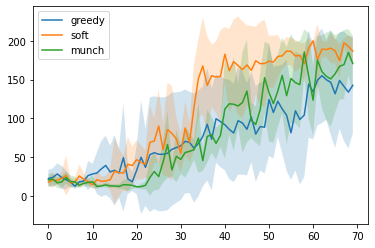

In [ ]:
GAMMA = 0.99
ALPHA = 0.9
TAU = 0.03

TD0_TARGET = td0_target(gamma=GAMMA)
TD0_SOFT_TARGET = td0_soft_target(gamma=GAMMA, tau=TAU)
TD0_MUNCH_TARGET = td0_munch_target(gamma=GAMMA, tau=TAU, alpha=ALPHA)

targets = {
  'greedy': TD0_TARGET,
  'soft': TD0_SOFT_TARGET,
  'munch': TD0_MUNCH_TARGET
}

results = run_comparison("CartPole-v0", targets=targets, runs=5)
plot(results)

What happens if I turn alpha higher? We'd expect it to slow down learning.

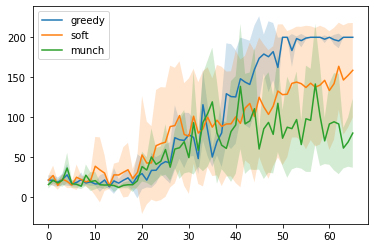

In [ ]:
GAMMA = 0.99
ALPHA = 0.99
TAU = 0.03

TD0_TARGET = td0_target(gamma=GAMMA)
TD0_SOFT_TARGET = td0_soft_target(gamma=GAMMA, tau=TAU)
TD0_MUNCH_TARGET = td0_munch_target(gamma=GAMMA, tau=TAU, alpha=ALPHA)

targets = {
  'greedy': TD0_TARGET,
  'soft': TD0_SOFT_TARGET,
  'munch': TD0_MUNCH_TARGET
}

results = run_comparison("CartPole-v0", targets=targets, runs=5)
plot(results)

Seems to have slowed down learning indeed! So increasing alpha slows down learning, and simultaneously increases the action gap (in theory). What does the action gap look like?

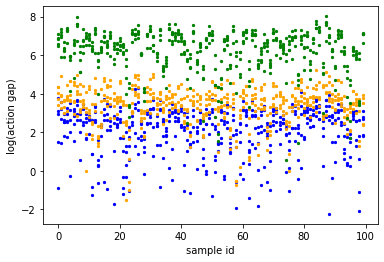

In [ ]:
NUM_SAMPLES = 100
samples = torch.randn(NUM_SAMPLES, 4)

cmap = {'greedy': 'b', 'soft': 'orange', 'munch': 'g'}

for result in results.items():
  name = result[0]
  qmodels = result[1]['qmodels']
  for qmodel in qmodels:
      q = qmodel.evaluate(samples)
      gap = (q.max(dim=1, keepdim=True).values - q)
      gap = gap.max(dim=1).values
      plt.scatter(range(samples.shape[0]), np.log(gap.numpy()), label=name, c=cmap[name], s=5.0)
      plt.ylabel('log(action gap)')
      plt.xlabel('sample id')
plt.show()

Woo! Munchausen! Intuitively makes sense that increased action gap <=> slower (but more stable) learning: there's more ground to cover to overtake the action gap when you're wrong.

### Convergence Rates

For $\alpha = 1$ (which is not a good idea in practice), there is a provable bound for Munchausen VI: 

$$||q_* - q_{\pi_k}||_\infty \leq \frac{2}{1 - \gamma} \big|\big| \frac{1}{k} \sum_{j=1}^k \epsilon_j \big| \big|_\infty + \frac{4}{(1 - \gamma)^2} \frac{r_{max} + \tau ln |\mathcal{A}|}{k}$$

Compared to typical propagation of errors of AVI without regularisation (such as DQN) found in [2]:

$$||q_* - q_{\pi_k}||_\infty  \leq \frac{2\gamma}{(1 - \gamma)}\sum_{j=1}^k \gamma^{k-j} ||\epsilon_j||_\infty + \frac{2}{1-\gamma}\gamma^kv_{max}$$

In the absence of error $\epsilon_j = 0 \forall j$, the convergence rate of DQN is faster $O(\gamma^k)$ versus $O(\frac{1}{k})$. However, if error is not zero, then M-VI has a preferable left-hand term since it takes an average over all errors before sup-norming, whereas AVI in general takes a recency-weighted sum over all previous errors. There is a weaker expression for error rates in the appendix for $0 \leq \alpha < 1$, but it's still got better properties than AVI/DQN.

# Applicability

### Principled, Effective, Simple, Cheap Regularisation for RL

**Effective regulariser for Reinforcement Learning:** Munchausen RL is a neat tool to add to the toolbox of methods to help stabilise deep RL. It's applicable in the sense of any regularisation method: it provides a practitioner with a hyperparameter to tune that might help them perform better in model-free RL, much like you might choose to use L1 or L2 regularisation in supervised learning, you can choose to do entropy regularisation and KL regularisation in RL.

**Empirical results**: The empirical results in the paper are essentially in line with this. They demonstrate that you can modify existing RL-algorithms with a Munchausen term, and tune for better performance. It's like looking at a problem in SL, introducing an effective regulariser and showing that you can tune the performance to be better.



### Shortcomings/Inapplicabilities



**Sparse rewards:** Munchausen regularisation is **not** a good idea in a setting where **exploration is key to success**. I don't think this is explicitly mentioned anywhere in the paper, but intuitively KL regularisation prevents you from reacting to information quickly. In the extreme example of **sparse** rewards, the implicit KL regularisation induced by the Munchausen term will cause the policy to **never be able to leave its initialisation**, (unless you get very lucky and the initial policy sets the agent up for a trajectory that actually hits some reward).


**Continuous setting:** The subtle brilliance of this idea is that it avoids approximation error in the policy update step, which means that **even with value approximation error you are guaranteed** to be doing _actual_ KL regularisation. However, if we were to try to migrate to the continuous case, we would run into **problems with using an actor** to maximise the value function to perform the policy update. Of course, these "problems" are only theoretical, it may be the case that the idea still works empirically, i.e. if the policy update error is sufficiently small.



Relies heavily on theory from

[1]:  Geist et. al, A Theory of Regularized MDPs, ICML 2019.

[2]: Vieillard et. al, Leverage the Average: an Analysis of KL Regularization in Reinforcement Learning, NeurIPS 2020.

Thanks for listening!

___
___
___

In [ ]:
def noisy(target_func, sigma=100.0):
    def _f(states, actions, rewards, next_states, dones, q_model):
        target = target_func(states, actions, rewards, next_states, dones, q_model)
        return target + sigma*torch.randn_like(target)
    return _f


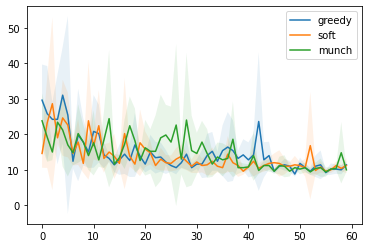

In [ ]:
greedy, soft, munch = run_comparison("CartPole-v0", runs=5)
plot(greedy, soft, munch)

In [ ]:
# Bloopers: tried to show it is more stable 